In [ ]:
!mkdir -p data models

In [1]:
%%writefile models/cond_unet.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.unet import UNet  # reuse your existing UNet components


class CrossAttentionBlock(nn.Module):
    def __init__(self, channels, cond_dim):
        super().__init__()
        self.norm = nn.GroupNorm(32, channels)
        self.to_q = nn.Conv2d(channels, channels, kernel_size=1)
        self.to_k = nn.Linear(cond_dim, channels)
        self.to_v = nn.Linear(cond_dim, channels)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)
    
    def forward(self, x, cond):
        # x: [B, C, H, W]; cond: [B, cond_dim]
        B, C, H, W = x.shape
        q = self.to_q(self.norm(x)).reshape(B, C, -1).permute(0, 2, 1)  # [B, H*W, C]
        # Use the condition as a single token
        k = self.to_k(cond).unsqueeze(1)  # [B, 1, C]
        v = self.to_v(cond).unsqueeze(1)  # [B, 1, C]
        attn = torch.bmm(q, k.transpose(1, 2)) * (C ** -0.5)  # [B, H*W, 1]
        attn = torch.softmax(attn, dim=-1)
        out = torch.bmm(attn, v)  # [B, H*W, C]
        out = out.permute(0, 2, 1).view(B, C, H, W)
        return x + self.proj_out(out)


class ConditionalUNet(UNet):
    def __init__(self, num_classes, cond_drop_prob=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.cond_drop_prob = cond_drop_prob
        # Embed class labels into a vector (here, dimension 256)
        self.class_emb = nn.Embedding(num_classes, 256)
        self.cross_attn = CrossAttentionBlock(self.mid_block1.conv2.out_channels, 256)
    
    def forward(self, x, t, class_label=None):
        if self.training and class_label is not None:
            if torch.rand(1).item() < self.cond_drop_prob:
                class_label = None
        if class_label is None:
            cond = torch.zeros(x.size(0), 256, device=x.device)
        else:
            cond = self.class_emb(class_label)
        
        t = t.to(x.device)
        t_emb = self.time_embedding(t)
        x = self.initial_conv(x)
        skip_connections_all = []
        for block in self.down_blocks:
            x, skip_connections = block(x, t_emb)
            skip_connections_all.append(skip_connections)
        x = self.mid_block1(x, t_emb)
        x = self.mid_attn(x)
        x = self.cross_attn(x, cond)
        x = self.mid_block2(x, t_emb)
        for block in self.up_blocks:
            skip_connections = skip_connections_all.pop()
            x = block(x, skip_connections, t_emb)
        x = self.final_norm(x)
        x = self.final_act(x)
        return self.final_conv(x)

Writing models/cond_unet.py


In [2]:
%%writefile models/cf_guided_diffusion.py
import torch
import torch.nn.functional as F
import pytorch_lightning as pl

class ClassifierFreeDiffusionModel(pl.LightningModule):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02, lr=1e-3, guidance_weight=5.0):
        super().__init__()
        self.model = model
        self.T = T
        self.lr = lr
        self.guidance_weight = guidance_weight

        beta = torch.linspace(beta_start, beta_end, T)
        alpha = 1.0 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        self.register_buffer("beta", beta)
        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_bar", alpha_bar)
        self.register_buffer("sqrt_alpha_bar", torch.sqrt(alpha_bar))
        self.register_buffer("sqrt_one_minus_alpha_bar", torch.sqrt(1 - alpha_bar))

    def forward(self, x, t, class_label=None):
        return self.model(x, t, class_label)
    
    def training_step(self, batch, batch_idx):
        x, labels = batch
        B = x.size(0)
        device = x.device
        t = torch.randint(0, self.T, (B,), device=device)
        sqrt_alpha_bar_t = self.sqrt_alpha_bar[t].view(B, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[t].view(B, 1, 1, 1)
        noise = torch.randn_like(x)
        x_t = sqrt_alpha_bar_t * x + sqrt_one_minus_alpha_bar_t * noise
        
        pred_noise = self(x_t, t, class_label=labels)
        loss = F.mse_loss(pred_noise, noise)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    @torch.no_grad()
    def sample(self, n_samples, class_label, ddim_steps=None):
        device = self.device
        if ddim_steps is None:
            ddim_steps = self.T
            step_size = 1
        else:
            step_size = self.T // ddim_steps
        
        x = torch.randn(n_samples, 1, 32, 32, device=device) 
        for i in range(self.T - 1, -1, -step_size):
            t = torch.full((n_samples,), i, device=device, dtype=torch.long)
            eps_cond = self(x, t, class_label=class_label)
            eps_uncond = self(x, t, class_label=None)
            eps = eps_uncond + self.guidance_weight * (eps_cond - eps_uncond)
            
            sqrt_alpha_bar_t = self.sqrt_alpha_bar[i].view(1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[i].view(1, 1, 1, 1)
            x0_pred = (x - sqrt_one_minus_alpha_bar_t * eps) / sqrt_alpha_bar_t
            t_prev = max(i - step_size, 0)
            sqrt_alpha_bar_t_prev = self.sqrt_alpha_bar[t_prev].view(1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t_prev = self.sqrt_one_minus_alpha_bar[t_prev].view(1, 1, 1, 1)
            x = sqrt_alpha_bar_t_prev * x0_pred + sqrt_one_minus_alpha_bar_t_prev * eps
        return x

Writing models/cf_guided_diffusion.py


In [3]:
%%writefile data/mnist.py
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

def get_mnist_dataloaders(batch_size=64, data_dir='./data'):
    transform = transforms.Compose([
        transforms.Resize(32),  # Ensures encoder outputs 4x4 feature maps after 3 downsamples
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale images to [-1, 1]
    ])

    train_dataset = MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_dataset  = MNIST(root=data_dir, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

Writing data/mnist.py


In [4]:
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from models.cond_unet import ConditionalUNet
from models.cf_guided_diffusion import ClassifierFreeDiffusionModel
from data.mnist import get_mnist_dataloaders

In [5]:
train_loader, test_loader = get_mnist_dataloaders(batch_size=64)

In [6]:
cond_unet = ConditionalUNet(
    num_classes=10,
    cond_drop_prob=0.1,
    in_channels=1,
    out_channels=1,
    base_channels=64,
    channel_mults=(1, 2, 4),
    num_res_blocks=2,
    time_emb_dim=256,
    attn_resolutions=[]
)

cf_diffusion = ClassifierFreeDiffusionModel(model=cond_unet, T=1000, lr=1e-3, guidance_weight=5.0)

In [8]:
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)
trainer.fit(cf_diffusion, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | ConditionalUNet | 14.2 M | train
--------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.699    Total estimated model params size (MB)
172       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [14]:
def plot_samples(samples, title):
    samples = (samples + 1) / 2  # scale to [0,1]
    fig, axes = plt.subplots(4, 4, figsize=(8,8))
    for i, ax in enumerate(axes.flatten()):
        img = samples[i].squeeze().detach().cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

samples = cf_diffusion.sample(n_samples=16, class_label=torch.full((16,), 3, dtype=torch.long))

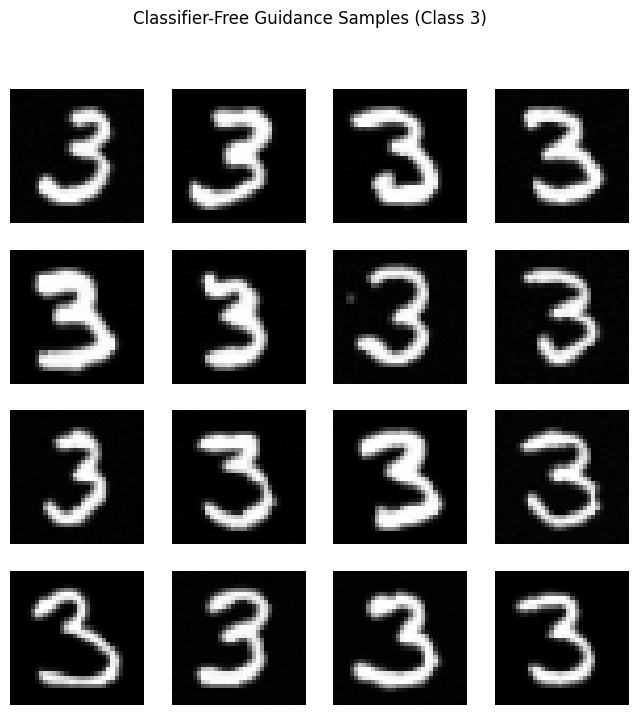

In [15]:
plot_samples(samples, "Classifier-Free Guidance Samples (Class 3)")